# Solution

## Goal
Explain how to reduce the **Type I error rate** in a statistical test, and demonstrate it with a small simulation.

In classical hypothesis testing, the **significance level** $\alpha$ is (by design) the probability of a **false rejection** when the null is true.
So reducing Type I error means reducing $\alpha$.

## Problem Statement
How do you reduce the type 1 error rate in a statistical test?

## Key idea (the one-line answer)
- **Type I error rate = $\alpha$** (under the null and assuming the test’s assumptions are met).
- To reduce Type I error, **lower $\alpha$** (e.g., 0.05 → 0.01).

### Common pitfall
Increasing sample size does **not** reduce the Type I error rate if you keep $\alpha$ fixed. Larger samples mainly affect **power** (Type II error), not the nominal Type I error.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Reproducibility
rng = np.random.default_rng(42)
plt.style.use('seaborn-v0_8-whitegrid')

## Demonstration 1 — Type I error is controlled by $\alpha$
We simulate a one-sample t-test under the null ($\mu=0$). If the null is true and assumptions hold, then:
- $P(\text{reject } H_0) \approx \alpha$
- and this holds across different sample sizes $n$ (up to Monte Carlo noise).

In [2]:
def type1_rate_one_sample_ttest(n, alpha, n_sims=20000, sigma=1.0):
    # Simulate under H0: mu=0
    x = rng.normal(loc=0.0, scale=sigma, size=(n_sims, n))
    # Vectorized t-test along axis=1
    _, p = stats.ttest_1samp(x, popmean=0.0, axis=1)
    return float(np.mean(p < alpha))

n_list = [10, 30, 100, 300, 1000]
alpha_list = [0.10, 0.05, 0.01]

rows = []
for a in alpha_list:
    for n in n_list:
        rows.append({'alpha': a, 'n': n, 'empirical_type1': type1_rate_one_sample_ttest(n=n, alpha=a)})

df_type1 = pd.DataFrame(rows).sort_values(['alpha', 'n'])
df_type1

,alpha,n,empirical_type1
10,0.01,10,0.00970
11,0.01,30,0.01130
12,0.01,100,0.00820
13,0.01,300,0.01015
14,0.01,1000,0.01040
5,0.05,10,0.05250
6,0.05,30,0.04920
7,0.05,100,0.04825
8,0.05,300,0.04850
9,0.05,1000,0.05290


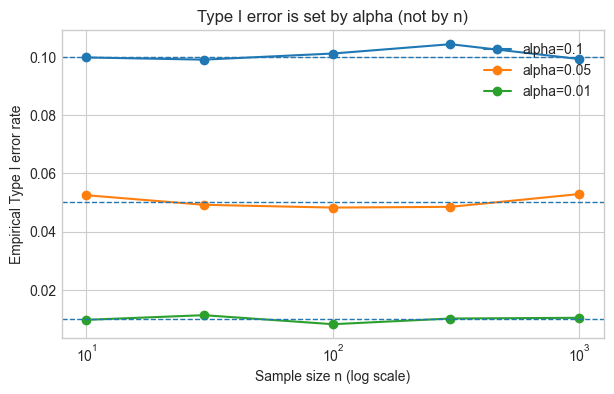

In [3]:
fig, ax = plt.subplots(figsize=(7, 4))
for a in alpha_list:
    sub = df_type1[df_type1['alpha'] == a]
    ax.plot(sub['n'], sub['empirical_type1'], marker='o', label=f'alpha={a}')
    ax.axhline(a, linestyle='--', linewidth=1)

ax.set_xscale('log')
ax.set_xlabel('Sample size n (log scale)')
ax.set_ylabel('Empirical Type I error rate')
ax.set_title('Type I error is set by alpha (not by n)')
ax.legend()
plt.show()

## Demonstration 2 — The trade-off (lower $\alpha$ usually lowers power)
Reducing $\alpha$ reduces false positives, but typically also reduces **power** for a fixed sample size and effect size.
We simulate under an alternative where the true mean is slightly positive.

In [4]:
def rejection_rate_one_sample_ttest(n, alpha, true_mu, n_sims=20000, sigma=1.0):
    x = rng.normal(loc=true_mu, scale=sigma, size=(n_sims, n))
    _, p = stats.ttest_1samp(x, popmean=0.0, axis=1)
    return float(np.mean(p < alpha))

n = 50
true_mu = 0.25  # small-ish effect
power_rows = []
for a in alpha_list:
    power_rows.append({'alpha': a, 'n': n, 'true_mu': true_mu, 'empirical_power': rejection_rate_one_sample_ttest(n=n, alpha=a, true_mu=true_mu)})
pd.DataFrame(power_rows).sort_values('alpha')

,alpha,n,true_mu,empirical_power
2,0.01,50,0.25,0.1967
1,0.05,50,0.25,0.4074
0,0.10,50,0.25,0.5412


## Multiple testing — why running more tests inflates Type I error
If you run $m$ independent tests at level $\alpha$, the probability of **at least one** false positive under the global null is:
$$\text{FWER} = 1 - (1-\alpha)^m.$$
This is larger than $\alpha$ when $m>1$.

Two common fixes (when controlling family-wise error is the goal):
- **Bonferroni**: test each hypothesis at $\alpha/m$
- **Holm (step-down)**: more powerful than Bonferroni while still controlling FWER

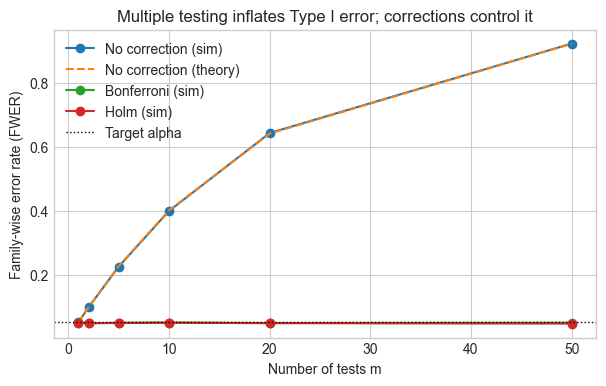

In [6]:
def fwer_nominal(alpha, m, n_sims=50000):
    # Under the global null, valid p-values are Uniform(0, 1).
    p = rng.random(size=(n_sims, m))
    return float(np.mean(np.any(p < alpha, axis=1)))

def fwer_bonferroni(alpha, m, n_sims=50000):
    p = rng.random(size=(n_sims, m))
    return float(np.mean(np.any(p < alpha / m, axis=1)))

def holm_reject_any(pvals, alpha):
    # Holm step-down (FWER control): returns True if at least one hypothesis is rejected.
    m = pvals.size
    p_sorted = np.sort(pvals)
    # Reject sequentially until the first failure; any rejection occurs if we pass at least i=0.
    for i in range(m):
        thresh = alpha / (m - i)
        if p_sorted[i] > thresh:
            return i > 0
    # If we never fail, we reject all hypotheses (so certainly 'any rejection' is True).
    return True

def fwer_holm(alpha, m, n_sims=20000):
    p = rng.random(size=(n_sims, m))
    out = [holm_reject_any(p[i], alpha) for i in range(n_sims)]
    return float(np.mean(out))

alpha = 0.05
m_list = [1, 2, 5, 10, 20, 50]

rows = []
for m in m_list:
    rows.append({
        'm': m,
        'alpha': alpha,
        'FWER_theory': 1 - (1 - alpha) ** m,
        'FWER_nominal_sim': fwer_nominal(alpha, m),
        'FWER_bonferroni_sim': fwer_bonferroni(alpha, m),
        'FWER_holm_sim': fwer_holm(alpha, m)
    })

df_fwer = pd.DataFrame(rows)
df_fwer

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(df_fwer['m'], df_fwer['FWER_nominal_sim'], marker='o', label='No correction (sim)')
ax.plot(df_fwer['m'], df_fwer['FWER_theory'], linestyle='--', label='No correction (theory)')
ax.plot(df_fwer['m'], df_fwer['FWER_bonferroni_sim'], marker='o', label='Bonferroni (sim)')
ax.plot(df_fwer['m'], df_fwer['FWER_holm_sim'], marker='o', label='Holm (sim)')
ax.axhline(alpha, color='black', linewidth=1, linestyle=':', label='Target alpha')

ax.set_xlabel('Number of tests m')
ax.set_ylabel('Family-wise error rate (FWER)')
ax.set_title('Multiple testing inflates Type I error; corrections control it')
ax.legend()
plt.show()

## Practical checklist
To reduce Type I error in real work:
- **Lower $\alpha$** (e.g., 0.05 → 0.01) when false positives are costly.
  - Many online experiments default to $\alpha=0.05$, while high-stakes domains (e.g., pharma) may use $\alpha=0.01$ or smaller.
- If you run many hypotheses, use **Bonferroni/Holm** (FWER) or FDR control (e.g., BH) depending on your goal.
- Avoid repeated *peeking* and changing decisions midstream without a valid sequential design.
- Pre-specify outcomes, metrics, and stopping rules to avoid unintentional $\alpha$ inflation.
- If you need lower Type I error *and* high power, you’ll typically need a **larger sample size** (power planning).

## Similar questions (from the source)
**1) What is worse in a product launch: Type I error or Type II error?**  
Often, a **Type I error** (shipping a change that is actually harmful) is worse because it can create bad user experiences and real downstream costs. A Type II error is typically an opportunity loss (missing an improvement).

**2) How do you reduce the Type II error rate?**  
Increase **power**. Since Type II error rate is $\beta = 1-\text{power}$, increasing power reduces $\beta$. Common levers: larger sample size, lower noise, larger detectable effect size, better measurement.

**3) If you run multiple tests, how does this affect Type I error?**  
It increases the chance of at least one false positive (FWER), roughly $1-(1-\alpha)^m$ under independence. Use multiplicity corrections when appropriate.

## Conclusion
Type I error is controlled by the chosen significance level $\alpha$. To reduce Type I error, reduce $\alpha$ (and manage multiplicity when testing many hypotheses).